In [37]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from shapely.geometry import box, Point, LineString
from shapely import affinity
import math

import os
path = os.getcwd()
# Get parent directory
parent = os.path.dirname(path)
#Add parent directory to system path
os.sys.path.insert(0, parent)


from lib.utils import *
from lib.plot_utils import *   
from lib.event_processing import *


In [38]:

catalog_path = '../data/catalogs/tycho2_VT_6.csv'
stars_data = get_star_dataset(type ='tycho', path = catalog_path)

print(stars_data.head())

    recno  TYC1  TYC2  TYC3  BTmag  VTmag      HIP   RA(ICRS)  DE(ICRS)
0    9734    58  1618     1  4.687  2.716  14135.0  45.569912  4.089921
1    9659    58   607     1  5.487  5.591  14143.0  45.593785  4.352873
2   10433    62  1579     1  6.849  5.680  14915.0  48.109873  6.660885
3  134397   641   985     1  4.567  4.681  13954.0  44.928738  8.907399
4  135691   650  1471     1  4.721  3.705  15900.0  51.203480  9.029056


In [186]:
def rotate_about_origin(x, y, origin, deg):
    x, y = np.asarray(x), np.asarray(y)
    ox, oy = origin

    xx = ox + (x-ox) * np.cos(np.deg2rad(deg)) + (y-oy) * np.sin(np.deg2rad(deg))
    yy = oy - (x-ox) * np.sin(np.deg2rad(deg)) + (y-oy) * np.cos(np.deg2rad(deg))
    
    return xx, yy


# coords = np.random.rand(1000, 2)
# ids = list(range(1, len(coords)+1))
# x, y = zip(*coords)

ids  = stars_data['HIP'].values
ids = ids.astype(int)
ids = ids.tolist()

coords = stars_data[['RA(ICRS)','DE(ICRS)']].values
x, y = zip(*coords)

catalogue = pd.DataFrame({'ID': ids, 'X': x, 'Y': y, 'grid': None})
catalogue['grid'] = catalogue['grid'].astype(object)

GRID_SIZE = 8
GRID_N = 20
SEARCH_RADIUS = GRID_SIZE

In [187]:
def make_pattern(star, close_stars):

    if not close_stars:
        return np.array([])

    grid = np.zeros((GRID_N, GRID_N))
    closest_star = min(close_stars, key=lambda x: np.sqrt((x[0] - star[0]) ** 2 + (x[1] - star[1]) ** 2))

    angle_to_rotate = math.atan2(closest_star[1] - star[1], closest_star[0] - star[0])

    unzipped_coords = list(zip(*close_stars))
    rotated_x, rotated_y = rotate_about_origin(
        unzipped_coords[0],
        unzipped_coords[1],
        (star[0], star[1]),
        np.rad2deg(angle_to_rotate)
    )

    x_linspace = np.linspace(star[0] - GRID_SIZE, star[0] + GRID_SIZE, num=GRID_N, endpoint=True)
    y_linspace = np.linspace(star[1] - GRID_SIZE, star[1] + GRID_SIZE, num=GRID_N, endpoint=True)[::-1]

    for close_star in list(zip(rotated_x, rotated_y)):
        x_idx = (np.abs(x_linspace - close_star[0])).argmin()
        y_idx = (np.abs(y_linspace - close_star[1])).argmin()
        grid[y_idx, x_idx] = 1

    return np.flatnonzero(grid)


"""""""""""""""""""""""""""""""""""""""""""""""""""
 Make grids/patterns for all stars in the catalogue
"""""""""""""""""""""""""""""""""""""""""""""""""""
for index, row in catalogue.iterrows():

    # This thing below includes current star
    close_stars_df = catalogue.loc[np.sqrt((catalogue['X']-row['X']) ** 2 + (catalogue['Y']-row['Y']) ** 2) <= SEARCH_RADIUS]

    # I'm pretty sure this is making a copy and not modifying the dataframe? I hope so.
    close_stars = list(zip(close_stars_df['X'].tolist(), close_stars_df['Y'].tolist()))

    # Get rid of the actual star we're considering
    close_stars.remove((row['X'], row['Y']))

    pattern = make_pattern((row['X'], row['Y']), close_stars)
    catalogue.loc[index, 'grid'] = [[pattern]]

    if not index % 10:
        print(f"Processed star nr: {index}")

Processed star nr: 0
Processed star nr: 10
Processed star nr: 20
Processed star nr: 30
Processed star nr: 40
Processed star nr: 50
Processed star nr: 60
Processed star nr: 70
Processed star nr: 80
Processed star nr: 90
Processed star nr: 100
Processed star nr: 110
Processed star nr: 120
Processed star nr: 130
Processed star nr: 140
Processed star nr: 150
Processed star nr: 160
Processed star nr: 170
Processed star nr: 180
Processed star nr: 190
Processed star nr: 200
Processed star nr: 210
Processed star nr: 220
Processed star nr: 230
Processed star nr: 240
Processed star nr: 250
Processed star nr: 260
Processed star nr: 270
Processed star nr: 280
Processed star nr: 290
Processed star nr: 300
Processed star nr: 310
Processed star nr: 320
Processed star nr: 330
Processed star nr: 340
Processed star nr: 350
Processed star nr: 360
Processed star nr: 370
Processed star nr: 380
Processed star nr: 390
Processed star nr: 400
Processed star nr: 410
Processed star nr: 420
Processed star nr: 430

accuracy:  0.9  %


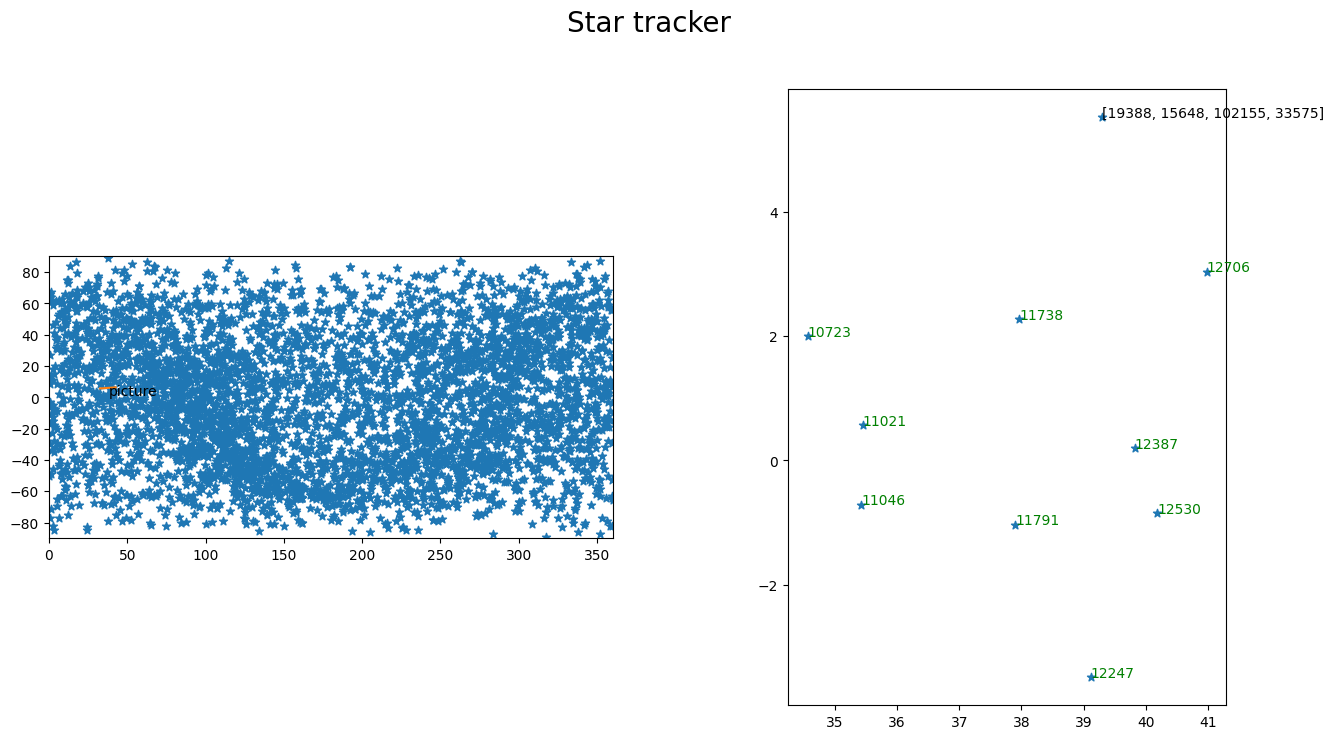

In [188]:
# This is making sure that the picture will fit
PICTURE_SIDE = 10
margin = PICTURE_SIDE * np.sqrt(2) / 2

# Random center 
# CENTER_OF_PICTURE = [np.random.randint(low=0+margin, high=360-margin, size=1), 
#                      np.random.randint(low=-00+margin, high=90-margin, size=1)]

# Selected center
CENTER_OF_PICTURE = [np.array([38]), np.array([1])]


"""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""
 Draw stars and make a picture frame, then collect stars inside
"""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""
fig, (ax, ax2) = plt.subplots(1, 2,figsize=(16, 8))
ax.set_aspect('equal', adjustable='box')
ax2.set_aspect('equal', adjustable='box')
fig.suptitle('Star tracker', fontsize=20)
ax.set_xlim(0, 360)
ax.set_ylim(-90, 90)

ax.scatter(x, y, marker='*')
# for i, id in enumerate(ids):
#     ax.annotate(id, (x[i], y[i]))

# Make a box/frame
b = box(
    CENTER_OF_PICTURE[0] - PICTURE_SIDE / 2,    # minx
    CENTER_OF_PICTURE[1] - PICTURE_SIDE / 2,    # miny
    CENTER_OF_PICTURE[0] + PICTURE_SIDE / 2,    # maxx
    CENTER_OF_PICTURE[1] + PICTURE_SIDE / 2     # maxy
)


picture_angle = np.random.randint(0, 90)
rotated_box = affinity.rotate(b, picture_angle, 'center')
box_representative_point = rotated_box.representative_point().coords[:][0]

ax.plot(*rotated_box.exterior.xy)
ax.annotate('picture', box_representative_point)

box_x, box_y = rotated_box.exterior.coords.xy
rotated_box_coords = list(zip(box_x, box_y))
top_line = LineString([rotated_box_coords[1], rotated_box_coords[2]])
ax.plot(*top_line.xy)
# top_line_representative_point = top_line.representative_point().coords[:][0]
# plt.annotate('top', top_line_representative_point)

# Collect points inside
points_in_picture = []

for p in coords:
    if rotated_box.contains(Point(p[0], p[1])):
        points_in_picture.append(p)

# Draw stars in the picture as the tracker sees them, just for show
#fig2, ax2 = plt.subplots(1, figsize=(6, 6))
# plt.xlim(0, 1)
# plt.ylim(0, 1)

cx, cy = zip(*points_in_picture)
rx, ry = rotate_about_origin(cx, cy, CENTER_OF_PICTURE, picture_angle)
ax2.scatter(rx, ry, marker='*')

"""""""""""""""""""""""""""""""""""""""""""""""""""""
 Search through the catalogue for all stars in picture
"""""""""""""""""""""""""""""""""""""""""""""""""""""

candidates = []
for star in points_in_picture:

    most_plausible_hits = []
    close_stars = [p for p in points_in_picture if (p != star).all() and np.sqrt((p[0]-star[0]) ** 2 + (p[1]-star[1]) ** 2) <= SEARCH_RADIUS]
    pattern = make_pattern(star, close_stars)
    max_intersect = 2   # Min amount of close stars we want to confirm

    # If we found less than 2 neighbours, it immediately disqualifies this star
    if len(pattern) < max_intersect:
        candidates.append([])
        continue

    # Search through the database and find possible candidates
    # (I know itterrows is lame but let's chill out, there's only like a 100 entries here)
    for index, row in catalogue.iterrows():
        row_patt = row['grid'][0]

        if len(row_patt) == len(pattern) and (row_patt == pattern).all():

            print('jackpot for', star, "match:", row['ID'])
            most_plausible_hits = [row['ID'], 'O']
            break

        intersect = len(np.intersect1d(row_patt, pattern))
        if intersect > max_intersect:
            max_intersect = intersect
            most_plausible_hits = [row['ID']]

        elif intersect == max_intersect:
            most_plausible_hits.append(row['ID'])

    candidates.append(most_plausible_hits)

"""""""""""""""""
 Display and label
"""""""""""""""""
all_cases = 0
true_cases = 0

for i, cand in enumerate(candidates):
    annotation = cand[0] if cand else ''

    if len(cand) == 1:                                             # We've got one most likely candidate, color it green
        ax2.annotate(annotation, (rx[i], ry[i]), color='green')
        true_id = catalogue.loc[(catalogue['X'] == cx[i]) & (catalogue['Y'] == cy[i])]['ID'].values[0]
        if true_id == annotation:
            true_cases += 1
        all_cases += 1
    elif 'O' in cand:                                              # We found a jackpot for this one, color it blue
        ax2.annotate(cand[0], (rx[i], ry[i]), color='blue')
        true_cases += 1
        all_cases += 1
    else:
        if len(cand)<5:                                             # If more than 5 candidates, don't annotate
            ax2.annotate(cand, (rx[i], ry[i]))                         # We have few, equally likely candidates for this
            all_cases += 1
        else:
            ax2.annotate(cand[0:4], (rx[i], ry[i]))                     # We have few, equally likely candidates for this
            all_cases += 1


if all_cases > 0:
    print("accuracy: ", true_cases/all_cases, " %")

else:
    print("duppa")

plt.show()

## REAL IMAGE EXAMPLE 

In [154]:
# Get system path 
import os
path = os.getcwd()
# Get parent directory
parent = os.path.dirname(path)
#Add parent directory to system path
os.sys.path.insert(0, parent)

from metavision_core.event_io import EventsIterator
import numpy as np
import matplotlib.pyplot as plt

from lib.utils import *
from lib.plot_utils import *   
from lib.event_processing import *

from metavision_core.event_io import EventsIterator
from metavision_sdk_core import PeriodicFrameGenerationAlgorithm
from metavision_sdk_ui import EventLoop, BaseWindow, Window, UIAction, UIKeyEvent

import cv2

Total frames:  278
Comapct frames:  27
Original clusters:  27 Fitered clusters:  9


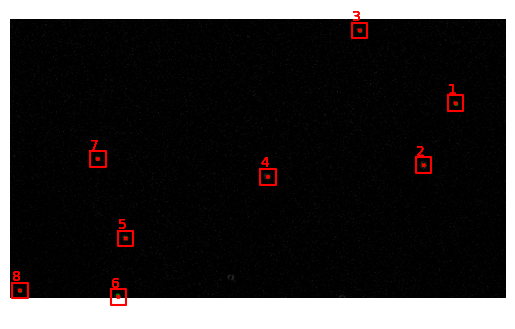

In [177]:
path = "../data/recordings/recording_2024-01-25_17-50-23.raw"
mv_iterator = EventsIterator(input_path=path, delta_t=1000)

height, width = mv_iterator.get_size()  # Camera Geometry
event_frame_gen = PeriodicFrameGenerationAlgorithm(width, height, accumulation_time_us=50000)

frames = []

def on_cd_frame_cb(ts, cd_frame):
    # window.show(cd_frame)
    frames.append(cd_frame)


event_frame_gen.set_output_callback(on_cd_frame_cb)

for evs in mv_iterator:
    event_frame_gen.process_events(evs)

print('Total frames: ',len(frames))

# Compact the frames
max_buffer = 10
blend = np.array(np.zeros((cv2.cvtColor(np.array(frames[0]), cv2.COLOR_BGR2GRAY).shape)))
copact_frames = []
count = 0
frames_buffer = []


for frame in frames:
    frames_buffer.append(frame)

    if len(frames_buffer) == max_buffer:
        blend = blend_buffer(frames_buffer, mirror=True)
        copact_frames.append(blend.astype(np.uint8))
        frames_buffer = []

print('Comapct frames: ',len(copact_frames))



treshold = 0.3 # Percetange of max value 

filtered_frames = []
clusters_list = []
pixel_range = 20

for frame in copact_frames:

    frame = cv2.blur(frame,(3,3))
    frame = cv2.normalize(frame, None, 0, 255, cv2.NORM_MINMAX)

    max_val = np.max(frame)
    frame_thr = cv2.threshold(frame, max_val*treshold, 1, cv2.THRESH_TOZERO)[1]
    

    filtered_frames.append(frame_thr)
    # cv_plot(frame_thr)
    clusters =  max_value_cluster(frame_thr, pixel_range, 20)
    clusters = sorted(clusters, key=lambda x: x[1], reverse=True)
    clusters_index = np.array([cluster[0] for cluster in clusters])
    clusters_index = sorted(clusters_index, key=lambda x: x[1], reverse=True)
    clusters_list.append( index_cluster(frame, pixel_range, clusters_index) )

#delete the clusters with a mass lower than a treshold
treshold = 0.43*np.max([cluster_mass[1] for cluster_mass in  clusters_list[12]])

clusters_list_filtered = [cluster for cluster in clusters_list[12] if cluster[1] > treshold ]

print('Original clusters: ', len(clusters_list),'Fitered clusters: ',  len(clusters_list_filtered))


#JUST TO CHECK SOM WITHOUT FALSE STARS
clusters_list_filtered.pop(4) # Remove the cluster 4 of the frame 12

plot_cluster(copact_frames[12], clusters_list_filtered, pixel_range)


In [189]:



"""""""""""""""""""""""""""""""""""""""""""""""""""""
 Search through the catalogue for all stars in picture
"""""""""""""""""""""""""""""""""""""""""""""""""""""
points_in_picture = [x[0] for x in clusters_list_filtered]

candidates = []
for star in points_in_picture:

    most_plausible_hits = []
    close_stars = [p for p in points_in_picture if (p != star).all() and np.sqrt((p[0]-star[0]) ** 2 + (p[1]-star[1]) ** 2) <= SEARCH_RADIUS]
    pattern = make_pattern(star, close_stars)
    max_intersect = 2   # Min amount of close stars we want to confirm

    # If we found less than 2 neighbours, it immediately disqualifies this star
    if len(pattern) < max_intersect:
        candidates.append([])
        continue

    # Search through the database and find possible candidates
    # (I know itterrows is lame but let's chill out, there's only like a 100 entries here)
    for index, row in catalogue.iterrows():
        row_patt = row['grid'][0]

        if len(row_patt) == len(pattern) and (row_patt == pattern).all():

            print('jackpot for', star, "match:", row['ID'])
            most_plausible_hits = [row['ID'], 'O']
            break

        intersect = len(np.intersect1d(row_patt, pattern))
        if intersect > max_intersect:
            max_intersect = intersect
            most_plausible_hits = [row['ID']]

        elif intersect == max_intersect:
            most_plausible_hits.append(row['ID'])

    candidates.append(most_plausible_hits)



In [190]:
candidates 

[[], [], [], [], [], [], [], []]